In [1]:
import sys
sys.path.append(r'D:\Python ML\SA-geochemical-maps\src')
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl


import create_chem_dataset as ccd
import max_dh_chem as mdc
from interpolation import MapBase, interpolate

import pandas as pd
import numpy as np

In [2]:
source_path = r'D:\Unearthed_SARIG_Data_Package\SARIG_Data_Package\sarig_rs_chem_exp.csv'
out_path = r'D:\Python ML\SA-geochemical-maps\Data\Processed_2'
drill_hole_spatial = r'D:\Python ML\SA-geochemical-maps\Data\interim\DH_data.csv'
method_path = r'D:\Python ML\SA-geochemical-maps\notebooks\chem_method_code_map.csv'


In [3]:
elements = ['Fe2O3','U','Ag','Pb','Cu','Zn','Co','Li','Ni','Fe','NiO', 'U3O8', 'Au', 'FeO', 'CoO']

element = 'Li'

In [4]:
clean_Li = ccd.create_dh_chem_data(source_path, element, method_path, out_path)


Need to remove spurious samples and holes as determined during the EDA phase, before determining max DH value

In [5]:
clean_Li.drop(clean_Li[clean_Li.DETERMINATION.str.contains(r'unknown', na=False, regex=False)].index, inplace=True)
clean_Li.drop(clean_Li[clean_Li.DETERMINATION.str.contains(r'UKN', na=False, regex=False)].index, inplace=True)
clean_Li.drop(clean_Li[clean_Li.DETERMINATION.str.contains(r'pXRF', na=False, regex=False)].index, inplace=True)



In [6]:
norm_data = mdc.max_dh_chem(clean_Li, drill_hole_spatial)

Normalise max dh data to average crustal abundance

In [7]:
norm_data['times_ave_crustal_abund'] = norm_data.converted_ppm.apply(lambda x: x / 17)

In [8]:
norm_data.head()

SAMPLE_NO SAMPLE_SOURCE_CODE  DRILLHOLE_NUMBER  DH_DEPTH_FROM  DH_DEPTH_TO  \
0    2078892               SLAB             148.0         340.00       350.00   
1    2054890                 CT          278558.0           0.00         5.00   
2    2078886               SLAB             149.0         467.70       468.10   
3    2132936                 CT             258.0         318.21       330.40   
4    2078891               SLAB             260.0         381.91       389.23   

   SAMPLE_ANALYSIS_NO ANALYSIS_TYPE_DESC               LABORATORY CHEM_CODE  \
0             1647439       GEOCHEMISTRY     ALS Chemex, Perth WA        Li   
1             1618145       GEOCHEMISTRY  ALS Chemex, Adelaide SA        Li   
2             1647432       GEOCHEMISTRY     ALS Chemex, Perth WA        Li   
3             1688387       GEOCHEMISTRY     ALS Chemex, Perth WA        Li   
4             1647438       GEOCHEMISTRY     ALS Chemex, Perth WA        Li   

   VALUE  ... BDL converted_ppm  DETERMINATION  DIGESTION   FUSION  \
0   20.0  ...   0          20.0         ICP-MS         FU     LB-F   
1   18.2  ...   0          18.2        ICP-AES         AR  unknown   
2   30.0  ...   0          30.0         ICP-MS         FU     LB-F   
3   20.0  ...   0          20.0         ICP-MS         FU     LB-F   
4   20.0  ...   0          20.0         ICP-MS         FU     LB-F   

           DH_NAME  SITE_NO LONGITUDE_GDA2020  LATITUDE_GDA2020  \
0             BN 1      182        129.166978        -31.168831   
1        13RSDRC01  1904509        135.727474        -32.152359   
2             BN 2      183        129.163525        -31.162481   
3     ALBALA-KAROO      278        129.581034        -31.461023   
4  GUINEWARRA BORE      280        129.933649        -31.460889   

   times_ave_crustal_abund  
0                 1.176471  
1                 1.070588  
2                 1.764706  
3                 1.176471  
4                 1.176471  

[5 rows x 22 columns]

In [9]:
norm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3958 entries, 0 to 3957
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SAMPLE_NO                3958 non-null   int64  
 1   SAMPLE_SOURCE_CODE       3956 non-null   object 
 2   DRILLHOLE_NUMBER         3958 non-null   float64
 3   DH_DEPTH_FROM            3957 non-null   float64
 4   DH_DEPTH_TO              3945 non-null   float64
 5   SAMPLE_ANALYSIS_NO       3958 non-null   int64  
 6   ANALYSIS_TYPE_DESC       3958 non-null   object 
 7   LABORATORY               3938 non-null   object 
 8   CHEM_CODE                3958 non-null   object 
 9   VALUE                    3958 non-null   float64
 10  UNIT                     3958 non-null   object 
 11  CHEM_METHOD_CODE         3958 non-null   object 
 12  BDL                      3958 non-null   int64  
 13  converted_ppm            3958 non-null   float64
 14  DETERMINATION           

In [10]:
norm_data.loc[norm_data['converted_ppm'].idxmax()]

SAMPLE_NO                                                      1931503
SAMPLE_SOURCE_CODE                                                  DC
DRILLHOLE_NUMBER                                              268238.0
DH_DEPTH_FROM                                                   1000.0
DH_DEPTH_TO                                                     1001.0
SAMPLE_ANALYSIS_NO                                             1506443
ANALYSIS_TYPE_DESC                                        GEOCHEMISTRY
LABORATORY                 Genalysis Laboratory Services Pty Ltd, W.A.
CHEM_CODE                                                           Li
VALUE                                                            810.1
UNIT                                                               ppm
CHEM_METHOD_CODE                                                 AT/MS
BDL                                                                  0
converted_ppm                                                    810.1
DETERM

In [11]:
norm_data.times_ave_crustal_abund.min()

5.882352941176471e-05

In [12]:
max_v, min_v = norm_data.times_ave_crustal_abund.max().astype(int), norm_data.times_ave_crustal_abund.min().astype(int) 
print(f'For the element {element}: the max value range is {max_v}, while the min is {min_v}')

proj = ccrs.epsg(3107)   #GDA 94/SA Lambert
levels = list(range(min_v, max_v, 1))
cmap = plt.get_cmap('plasma')
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
log_norm = LogNorm()
n_dh = len(norm_data.DRILLHOLE_NUMBER)

For the element Li: the max value range is 47, while the min is 0


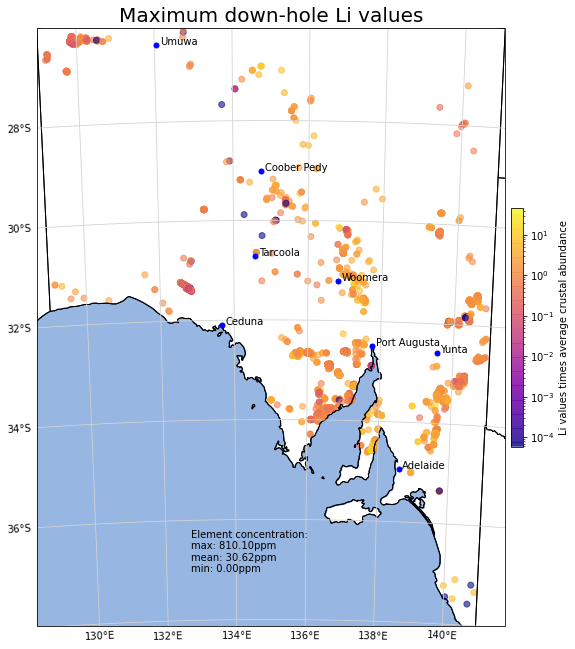

In [13]:
mpl.rcParams['agg.path.chunksize'] = 10000

title = f'Maximum down-hole {element} values'
label = f'{element} values times average crustal abundance'
out_fig = out_path+'\\'+f'Max_downhole_{element}.jpg'
inset_title = f'Number of drill holes:\n{n_dh}'
x, y = norm_data.LONGITUDE_GDA2020.values, norm_data.LATITUDE_GDA2020.values
max_val, min_val, mean_val = norm_data.converted_ppm.max(), norm_data.converted_ppm.min(), norm_data.converted_ppm.mean()
annot = f'Element concentration:\nmax: {max_val:.2f}ppm\nmean: {mean_val:.2f}ppm\nmin: {min_val:.2f}ppm'

fig, view, inset = MapBase(proj, title, inset_title, add_inset=False)
plot = view.scatter(x, y, c=norm_data.times_ave_crustal_abund, cmap=cmap, norm=log_norm, alpha=0.6, transform=ccrs.PlateCarree())
fig.colorbar(plot, ax=view, shrink=.4, pad=0.01, label=label) #boundaries=levels, 
#inset.plot(x, y,color='blue', marker='o', markersize=2, linestyle='None', transform=ccrs.Geodetic())
    
view.annotate(text=annot, xy=(0.33,0.09), xycoords='axes fraction')
plt.savefig(out_fig, dpi=300, bbox_inches='tight')
plt.show()

In [14]:
gx, gy, img = interpolate(norm_data, proj)

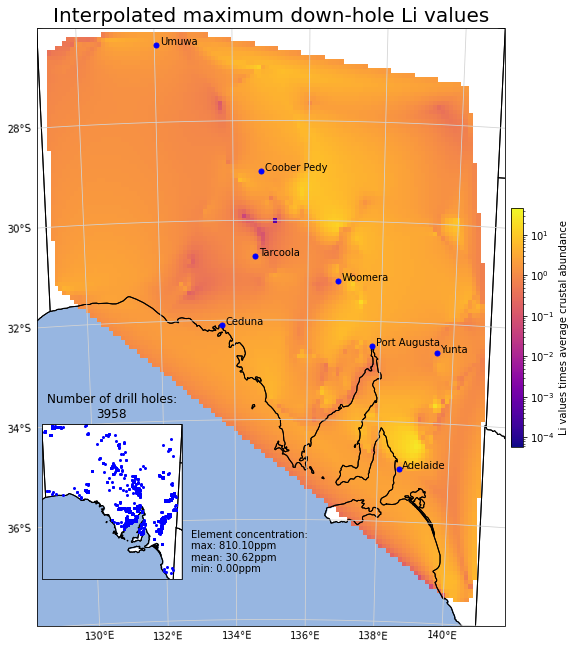

In [15]:
title = f'Interpolated maximum down-hole {element} values'
label = f'{element} values times average crustal abundance'
out_fig = out_path+'\\'+f'Interp_Max_downhole_{element}.jpg'
inset_title = f'Number of drill holes:\n{n_dh}'
x, y = norm_data.LONGITUDE_GDA2020.values, norm_data.LATITUDE_GDA2020.values
max_val, min_val, mean_val = norm_data.converted_ppm.max(), norm_data.converted_ppm.min(), norm_data.converted_ppm.mean()
annot = f'Element concentration:\nmax: {max_val:.2f}ppm\nmean: {mean_val:.2f}ppm\nmin: {min_val:.2f}ppm'

fig, view, inset = MapBase(proj, title, inset_title)
mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=log_norm)
fig.colorbar(mmb, ax=view, shrink=.4, pad=0.01, label=label) #boundaries=levels, 
inset.plot(x, y,color='blue', marker='o', markersize=2, linestyle='None', transform=ccrs.Geodetic())
    
view.annotate(text=annot, xy=(0.33,0.09), xycoords='axes fraction')
plt.savefig(out_fig, dpi=300, bbox_inches='tight')
plt.show()